In [41]:
import os
import shutil
import tempfile
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import glob

import monai
import nibabel as nib

from monai.config import print_config
#from monai.data import DataLoader
from monai.data import CacheDataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.metrics import compute_meandice
from monai.networks.nets import UNet
from monai.networks.layers import Norm
#from monai.utils.misc import first
from monai.transforms import (
    AsChannelFirstd,
    AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadNiftid,
    MapTransform,
    RandCropByPosNegLabeld,
    RandGaussianNoised,
    NormalizeIntensityd,
    Resized,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    DivisiblePadd,
    Spacingd,
    RandRotated,
    ResizeWithPadOrCropd,
    ToTensord,
)
from monai.utils import set_determinism

from fastai.vision.all import *
from pathlib import Path
import pandas as pd
from fastai.data.all import *
from fastai.torch_basics import *
from tqdm import tqdm_notebook as tqdm
import shutil

print_config()

MONAI version: 0.3.0+67.g90cd680
Python version: 3.7.7 (default, Mar 26 2020, 15:48:22)  [GCC 7.3.0]
OS version: Linux (4.15.0-121-generic)
Numpy version: 1.19.1
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.0
scikit-image version: 0.17.2
Pillow version: 7.0.0
Tensorboard version: 2.3.0
gdown version: 3.12.2
TorchVision version: 0.7.0
ITK version: 5.1.0
tqdm version: 4.48.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
set_determinism(seed=4096)

In [3]:
rootdir= os.getcwd()
dfTrain = pd.read_csv(f'{rootdir}/dfTrainSel.csv')
dfVal = pd.read_csv(f'{rootdir}/dfValSel.csv')
dfTest = pd.read_csv(f'{rootdir}/dfTestSel.csv')

In [4]:
# dfTrain = dfTrain.loc[dfTrain['usage'] == 'train']
# dfTrain.to_csv('dfTrainSel.csv', index=False, header=True)

In [5]:
dfTrain.count()

path                   2132
age_at_scan            2132
gender                 2132
subject_id             2132
img_id                 2132
source                 2132
path_bias              2132
brain_mask_bias_nn     2132
brain_mask_bias_lin    2132
rounded_age            2132
age_group              2132
usage                  2132
dtype: int64

In [6]:
train_files= [{'image':impath, 'label': lblpath} for impath, lblpath in zip(dfTrain['path_bias'], dfTrain['brain_mask_bias_nn'])]
val_files= [{'image':impath, 'label': lblpath} for impath, lblpath in zip(dfVal['path_bias'], dfVal['brain_mask_bias_nn'])]
test_files= [{'image':impath, 'label': lblpath} for impath, lblpath in zip(dfTest['path_bias'], dfTest['brain_mask_bias_nn'])]

In [7]:
# train_files = train_files[:24]
# val_files = val_files[:8]
# test_files = test_files[:8]

In [8]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        #ConvertbinaryMaskd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        DivisiblePadd(keys=["image", "label"], k=16, mode=('edge')),
#        RandCropByPosNegLabeld(keys=["image", "label"], label_key="label",spatial_size=(160, 160, 96), pos=2, neg=1, num_samples=2, image_key="image"),
        
        Resized(keys=["image", "label"], spatial_size = (160, 160, 96), mode=("trilinear", "nearest")),
#        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size = (128, 128, 64), mode=('edge')),
##         #RandSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 92], random_size=False),
        RandRotated(keys = ['image', 'label'], range_x = [-10, 10], prob = 0.5, mode=("bilinear", "nearest")),
# #         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=False),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
# #         RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [     
         LoadNiftid(keys=["image", "label"]),
         AddChanneld(keys=['image','label']),
         #ConvertbinaryMaskd(keys="label"),
         Orientationd(keys=["image", "label"], axcodes="RAS"),
         Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
         #CenterSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 92]),
         #ResizeWithPadOrCropd(keys=["image", "label"], spatial_size = (256, 256, 176), mode=('edge')),
         DivisiblePadd(keys=["image", "label"], k=16, mode=('edge')),
         Resized(keys=["image", "label"], spatial_size = (160, 160, 96), mode=("trilinear", "nearest")),
         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=False),
         ToTensord(keys=["image", "label"]),
    ]
)

infer_transform = Compose(
    [     
         LoadNiftid(keys=["image", "label"]),
         AddChanneld(keys=['image','label']),
         #ConvertbinaryMaskd(keys="label"),
         Orientationd(keys=["image", "label"], axcodes="RAS"),
         Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
         #CenterSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 92]),
         #ResizeWithPadOrCropd(keys=["image", "label"], spatial_size = (256, 256, 176), mode=('edge')),
         #DivisiblePadd(keys=["image", "label"], k=16, mode=('edge')),
         #Resized(keys=["image", "label"], spatial_size = (128, 128, 64), mode=("trilinear", "nearest")),
         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=False),
         ToTensord(keys=["image", "label"]),
    ]
)


In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transform, cache_rate=1.0, num_workers=8)

Load and cache transformed data: 100%|██████████| 2132/2132 [21:19<00:00,  1.67it/s]


In [10]:
val_ds = CacheDataset(data=val_files, transform=val_transform, cache_rate=1.0, num_workers=8)

Load and cache transformed data: 100%|██████████| 658/658 [08:34<00:00,  1.28it/s]


In [11]:
torch.cuda.set_device('cuda:1')

### Another way of making dataloader

In [12]:
class faiTransFacollateDsets1(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        self.imagekey, self.labelkey = (0,1) if isinstance(self.files[0][0], tuple) else (list(self.files[0][0].keys())[0],list(self.files[0][0].keys())[1])

    def encodes(self, i):
        file1 = self.files[i]
        #file1=fa_collate(file1)
        listimglabel=[]
        for j in range(len(file1)):
           
            image,label = file1[j][self.imagekey], file1[j][self.labelkey]
            listimglabel.append((image,label))
        return listimglabel
    
class faiTransformDsets(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        #self.imagekey, self.labelkey=list(self.files[0].keys())[0], list(self.files[0].keys())[1]
        self.imagekey, self.labelkey = (0,1) if isinstance(self.files[0], tuple) else (list(self.files[0].keys())[0],list(self.files[0].keys())[1])

    def encodes(self, i):
        file1 = self.files[i]
        #trstatus = torch.tensor(0.) if self.is_valid else torch.tensor(1.)   
        image,label = file1[self.imagekey], file1[self.labelkey]
        return (image, label)

In [13]:
train_tl= TfmdLists(range(len(train_ds)), faiTransformDsets(train_ds))

In [14]:
#train_tl[0][0][0].shape, train_tl[0][0][1].unique()

In [15]:
valid_tl= TfmdLists(range(len(val_ds)), faiTransformDsets(val_ds, is_valid=True))

In [16]:
def create_batch(data):
    ixd=0
    mxL={}
    imglist, labellist=[],[]
    rrtuple = ()
    for ix, d in enumerate(data):
        #batchdata=data[ix] ### So that it does not shuffle here
        
         
        if isinstance(d, list):
            imagekey, labelkey = (0,1) if isinstance(d[0], tuple) else (list(d[0].keys())[0],list(d[0].keys())[1])
            
            
            for di in range(len(d)):
                imglist.append(d[di][imagekey])
                labellist.append(d[di][labelkey])
            rrtuple = torch.stack(imglist, dim=0), torch.stack(labellist, dim=0)
                
        elif isinstance(d, dict):
            
            imagekey, labelkey = (list(d.keys())[0],list(d.keys())[1])
            
            
            
            if len(data) == 1:

                rrtuple = d[imagekey].unsqueeze(dim=0), d[labelkey].unsqueeze(dim=0)
                
            else:
                
                imglist.append(d[imagekey])
                labellist.append(d[labelkey])
                
                rrtuple = torch.stack(imglist, dim=0), torch.stack(labellist, dim=0)
                
        elif isinstance(d, tuple):
            
            imagekey, labelkey = (0,1) 
            
            
            
            if len(data) == 1:

                rrtuple = d[imagekey].unsqueeze(dim=0), d[labelkey].unsqueeze(dim=0)
                
            else:
                
                imglist.append(d[imagekey])
                labellist.append(d[labelkey])
                
                rrtuple = torch.stack(imglist, dim=0), torch.stack(labellist, dim=0)
            
            
        else:
            print('Do nothing, Check inputs properly')
            
    return rrtuple

In [17]:
dlsTrain=TfmdDL(train_tl,bs=8, num_workers=8, create_batch=create_batch)
dlsTrain1 = dlsTrain.one_batch()

In [18]:
dlsVal=TfmdDL(valid_tl, bs=8, num_workers=8, create_batch=create_batch)
dlsVal1 = dlsVal.one_batch()

In [19]:
dls = DataLoaders(dlsTrain,dlsVal)
dls.cuda()

In [20]:
from faiutils import dlsshowbatch ##NiftiImageTuple   ###dlsshowbatch,
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, slice_nr=None, figorder=2,  **kwargs):
    dlsshowbatch11 = dlsshowbatch(x=x, y=y, samples=samples, ctxs=ctxs, max_n=max_n, nrows=nrows, ncols=ncols, figsize=figsize, slice_nr=slice_nr, figorder=figorder, **kwargs)
    #show_batch(x=x, y=y, samples=samples, ctxs=ctxs, max_n=max_n, nrows=nrows, ncols=ncols, figsize=figsize, slice_nr=slice_nr, figorder=figorder, **kwargs) 
    dlsshowbatch11.show_batch()

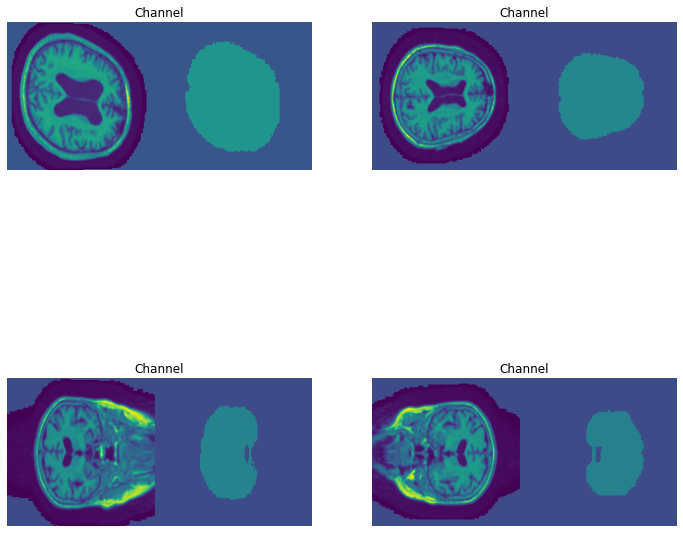

In [21]:
dls.show_batch(figorder=2)

### Defining a model here

In [22]:
# # # standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
# device = torch.device("cuda:0")
# model = UNet(
#     dimensions=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
#     dropout=0.5,
#     #num_res_units=16
# ).to(device)
# #loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True) #### Spleen example
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, amsgrad=True)

### Script for setting kernel size and strides

In [23]:
# spacings = (1.0, 1.0, 1.0)
# sizes = (160, 160, 96)


# n_class, in_channels = 2, 1
# best_dice, best_epoch = (n_class - 1) * [0], (n_class - 1) * [0]
# strides, kernels = [], []

# while True:
#     spacing_ratio = [sp / min(spacings) for sp in spacings]
#     stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
#     kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
 
#     if all(s == 1 for s in stride):
#         break
#     sizes = [i / j for i, j in zip(sizes, stride)]
#     spacings = [i * j for i, j in zip(spacings, stride)]
#     kernels.append(kernel)
#     strides.append(stride)

# strides.insert(0, len(spacings) * [1])
# kernels.append(len(spacings) * [3])

In [24]:
#torch.cuda.set_device('cuda:1')
device = torch.device("cuda:1")
n_class, in_channels = 2, 1

# kernels = [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
# strides =[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 1]]
# ####Out of memory above

kernels = [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
strides =[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 1]]

model = monai.networks.nets.DynUNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=n_class,
    kernel_size=kernels,
    strides=strides,
    upsample_kernel_size=strides[1:],
    norm_name="instance",
    deep_supervision=False,
    deep_supr_num=1,
    res_block=False,
).to(device)

In [25]:
# xxinp = torch.randn(1, 1, 176, 176, 92).to(device)
# here = model(xxinp)
# here.shape

In [26]:
#torch.backends.cudnn.deterministic = True
patch_size = (160, 160, 96)
sw_batch_size, overlap = 4, 0.5
inferer = monai.inferers.SlidingWindowInferer(
    roi_size=patch_size,
    sw_batch_size=sw_batch_size,
    overlap=overlap,
    mode="gaussian",
    padding_mode="replicate",
)

In [27]:
#monai.inferers.SlidingWindowInferer?

In [28]:
class DiceEx(Dice):
    
    #def __init__(self, axis=1): self.axis = axis
        
    def reset(self): 
        self.metricX= 0.0
    
    def accumulate(self, learn):
      
        #dice_metric = DiceMetric(include_background=True, sigmoid=True, to_onehot_y=True, reduction="mean")
        #metric_sum =  metric_sum_wt  = 0.0
        #metric_count  = metric_count_wt  = 0
        value1 = 0.0

        val_pred=learn.pred
        val_targ = learn.y
        val_input=learn.x
        #targ=targ.unsqueeze(dim=1)
     
        swival_pred= inferer(val_input, learn.model)
        value1=compute_meandice(y_pred=swival_pred, y=val_targ, include_background=False, to_onehot_y=True, mutually_exclusive=True)
        #self.metricX = value1.mean().item()
        self.metricX = value1.item()
        value1 = 0.0
    
 
    @property
    def value(self): return self.metricX 

In [29]:
class SlidingWDiceCELoss(Module):
    def __init__(self):
        #super().__init__()
        self.dice = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, output, target):
        dice=self.dice(output,target)
        cross_entropy = self.cross_entropy(output, torch.squeeze(target, dim=1).long())
        return dice + cross_entropy
       
 
####### Applying check dimension and shapes
#         if (output[0,0,:,:,:].shape==target[0,0,:,:,:].shape) == True: 
#             dice=self.dice(output,target)
#             cross_entropy = self.cross_entropy(output, torch.squeeze(target, dim=1).long())
#             return dice + cross_entropy
                      
#         else:
            
#             #breakpoint()
#             print('Define appropriate loss function')

    def activation(self, out): return out
    def decodes(self, out):    return out

#     def activation(self, out): return F.softmax(out, dim=-1)
#     def decodes(self, out):    return out.argmax(dim=-1)

In [30]:
learn = Learner(dls, model, loss_func=SlidingWDiceCELoss(), opt_func=Adam, cbs=[NativeMixedPrecision(), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=20)])  ###.to_native_fp16()
learn.freeze()

(0.025118863582611083, 0.2089296132326126)

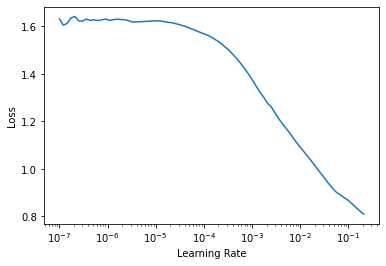

In [31]:
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [32]:
learn.unfreeze()
learn.fine_tune(100, freeze_epochs=20)

epoch,train_loss,valid_loss,time
0,0.206293,0.227473,44:36
1,0.138096,0.156215,44:40
2,0.095913,0.104706,44:37
3,0.074042,0.079964,44:42
4,0.062747,0.061111,44:45
5,0.061703,0.063209,44:46
6,0.057705,0.053661,44:48
7,0.058158,0.056934,44:47
8,0.057914,0.050929,44:47
9,0.055640,0.047800,44:42


epoch,train_loss,valid_loss,time
0,0.045442,0.040188,42:13
1,0.044939,0.039668,44:46
2,0.044637,0.039231,44:53
3,0.044343,0.038982,44:52
4,0.044094,0.038920,44:54
5,0.043871,0.039084,44:51
6,0.043646,0.039185,44:57
7,0.043440,0.039079,42:58
8,0.043287,0.039140,41:58
9,0.043177,0.039297,44:14


KeyboardInterrupt: 

In [34]:
# learn.unfreeze()
# lrr = slice(2e-5,2e-3)
# learn.fit_one_cycle(50, lr_max=lrr)

In [49]:
# lrnmdl = learn.model
# lrnmdl.eval()

In [35]:
with torch.no_grad():
    learn.model.eval()
    
    valscore = []
    count = 0

    
    for batch in dls.valid:
        val_input, val_targ = batch[0], batch[1]
        #breakpoint()
        #swival_pred= (inferer(val_input, learn.model).sigmoid() >= 0.5).float()
        #value1=compute_meandice(y_pred=swival_pred, y=val_targ, include_background=False, to_onehot_y=True, mutually_exclusive=True)
        
        val_pred = (learn.model(val_input).sigmoid()>=0.5).float()
        value1=compute_meandice(y_pred=val_pred, y=val_targ, include_background=False)
        #valscore.append(value1.item())
        
        ###if batch size is greater than 1 on validation dataset
        valscore.append(value1.mean().item())
        
        count = count+1  

In [36]:
from statistics import mean as mnsss
from statistics import stdev as stddev
mnsss(valscore), stddev(valscore)

(0.975007957004639, 0.009290112648009054)

### On test dataset

In [43]:
learn.model.eval()

with torch.no_grad():
    
    infer_ds = monai.data.Dataset(data=test_files, transform=infer_transform)
    infer_loader = monai.data.DataLoader(
        infer_ds,
        batch_size=1,  # image-level batch to the sliding window method, not the window-level batch
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
    )
    
    patch_size = (160, 160, 96)
    sw_batch_size, overlap = 4, 0.5
    inferer = monai.inferers.SlidingWindowInferer(
    roi_size=patch_size,
    sw_batch_size=sw_batch_size,
    overlap=overlap,
    mode="gaussian",
    padding_mode="replicate",
)
    
    valscore = []
    count = 0
    keys = ("image","label")   
 
    #for batch in dls.valid: 
    
    test_files
    
    for indxx, infer_data in enumerate(tqdm(infer_loader)):
        sleep(0.01)

        #breakpoint()
        val_targ=infer_data[keys[1]].to(device)
        swival_preds= inferer(infer_data[keys[0]].to(device), learn.model)
        n = 1.0
        for _ in range(4):
            # test time augmentations
            
            _img = RandGaussianNoised(keys[0], prob=1.0, std=0.01)(infer_data)[keys[0]]
            
            pred = inferer(_img.to(device), learn.model)
            swival_preds = swival_preds + pred
            n = n + 1.0
            
            for dims in [[2], [3]]:
                    flip_pred = inferer(torch.flip(_img.to(device), dims=dims), learn.model)
                    pred = torch.flip(flip_pred, dims=dims)
                    swival_preds = swival_preds + pred
                    n = n + 1.0
                    
        swival_preds = swival_preds / n
        #swival_preds= (inferer(val_input, learn.model).sigmoid() >= 0.5).float()
        swival_preds = (swival_preds.argmax(dim=1, keepdims=True)).float()
       
        value1=compute_meandice(y_pred=swival_preds, y=val_targ, include_background=False)
        valscore.append(value1.item())  
        count = count+1 

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [44]:
mnsss(valscore), stddev(valscore)

(0.9586155312989779, 0.023433485185930143)

In [53]:
def showSegSWIinference(tlearn, test_files, val_transform, patch_size, sw_batch_size = 4, overlap=0.5, withMask = True, nsubs = 2 , slice_nr = 25, device=torch.device('cuda:1')):

    with torch.no_grad():
        
        tlearn.model.eval()
        
        #patch_size = (160, 160, 96)
        patch_size=patch_size
        sw_batch_size, overlap = sw_batch_size, overlap
        inferer = monai.inferers.SlidingWindowInferer(
        roi_size=patch_size,
        sw_batch_size=sw_batch_size,
        overlap=overlap,
        mode="gaussian",
        padding_mode="replicate",
        )
        

        if withMask:

            test_ds = CacheDataset(data=test_files, transform=infer_transform)
            image, label = (0,1) if isinstance(test_ds[0], tuple) else (list(test_ds[0].keys())[0],list(test_ds[0].keys())[1])
            subs = torch.randperm(nsubs) if nsubs<=len(test_ds) else torch.randperm(len(test_ds))
            nclass = test_ds[0][label].shape[0]
            nchannels = test_ds[0][image].shape[0]
            
            
            for iSub in subs:
                val_input, val_targ = test_ds[iSub][image], test_ds[iSub][label]
                #breakpoint()
                swival_pred= inferer(val_input.unsqueeze(0).to(device), tlearn.model)
                #value1=compute_meandice(y_pred=swival_pred, y=val_targ, include_background=False)
                
                plt.figure("image", (24, 6))
                ####Input image
                plt.subplot(1, 3, 1)
                plt.title(f"image channel-single")
                plt.imshow(val_input[0, :, :, slice_nr], cmap="gray")

                #### Input Mask

                plt.subplot(1, 3, 2)
                plt.title(f"label channel-single")
                plt.imshow(val_targ[0, :, :, slice_nr], cmap="gray")

                plt.subplot(1, 3, 3)
                plt.title(f"Predicted skull stripped output")
                plt.imshow((swival_pred[0, 0, :, :, slice_nr].sigmoid() <= 0.5).float().detach().cpu(), cmap="gray")

                plt.show()



        else:
            fakeim, fakeseg = monai.data.synthetic.create_test_image_3d(256, 256, 256)
            n = nib.Nifti1Image(fakeseg, np.eye(4))
            nib.save(n, os.path.join(os.getcwd(), "segfake1.nii.gz"))
            #nib.load(os.path.join(os.getcwd(), f"segfake1.nii.gz"))
            labelpath = len(test_files)*[os.path.join(os.getcwd(), "segfake1.nii.gz")]

            test_files = [{'image':image, 'label': label} for image, label in zip(test_files, labelpath)]
            test_ds = CacheDataset(data=test_files, transform=val_transform)
            image, label = (0,1) if isinstance(test_ds[0], tuple) else (list(test_ds[0].keys())[0],list(test_ds[0].keys())[1])
            subs = torch.randperm(nsubs) if nsubs<=len(test_ds) else torch.randperm(len(test_ds))
            nclass = test_ds[0][label].shape[0]
            nchannels = test_ds[0][image].shape[0]
            
            
                                
            for iSub in subs:
                val_input= test_ds[iSub][image]
                #breakpoint()
                swival_pred= inferer(val_input.unsqueeze(0).to(device), tlearn.model)
                #value1=compute_meandice(y_pred=swival_pred, y=val_targ, include_background=False)
                
                plt.figure("image", (24, 6))
                ####Input image
                plt.subplot(1, 3, 1)
                plt.title(f"image channel-single")
                plt.imshow(val_input[0, :, :, slice_nr], cmap="gray")


                plt.subplot(1, 3, 2)
                plt.title(f"Predicted skull stripped output")
                plt.imshow((swival_pred[0, 0, :, :, slice_nr].sigmoid() <= 0.5).float().detach().cpu(), cmap="gray")

                plt.show()

Load and cache transformed data: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


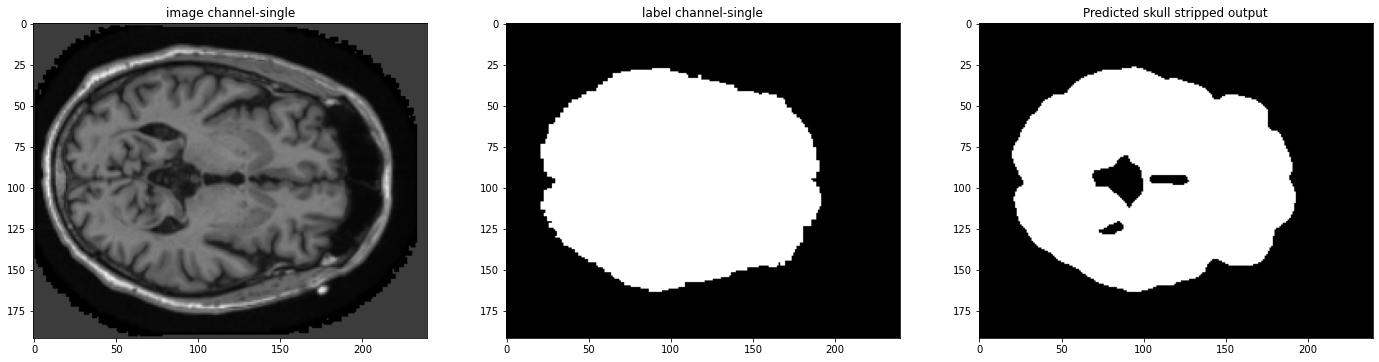

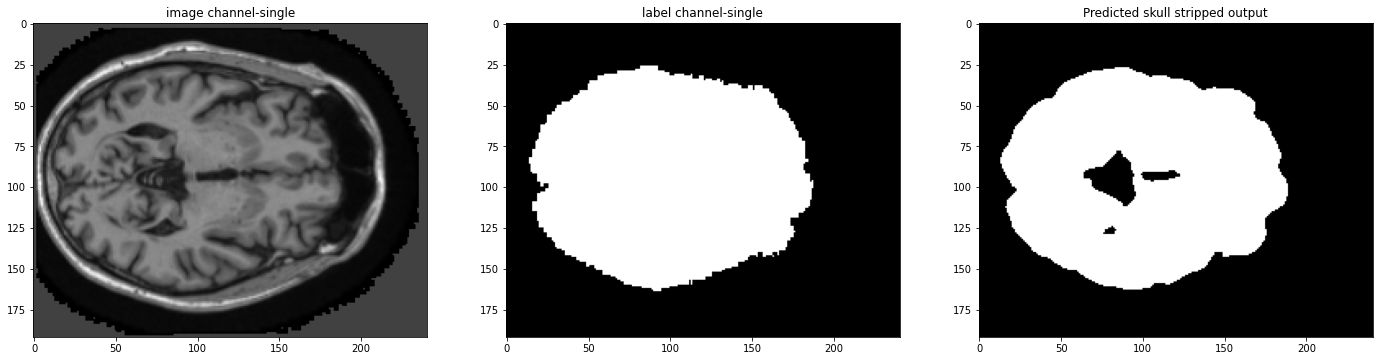

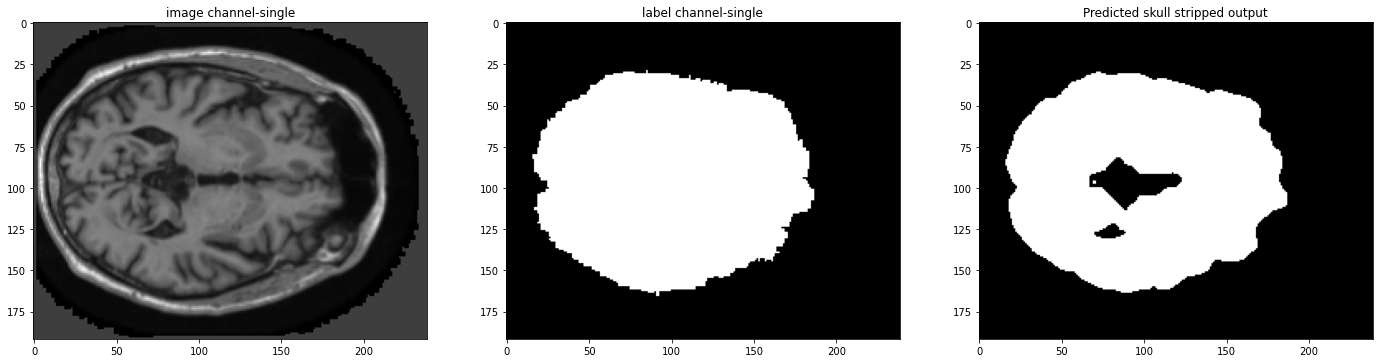

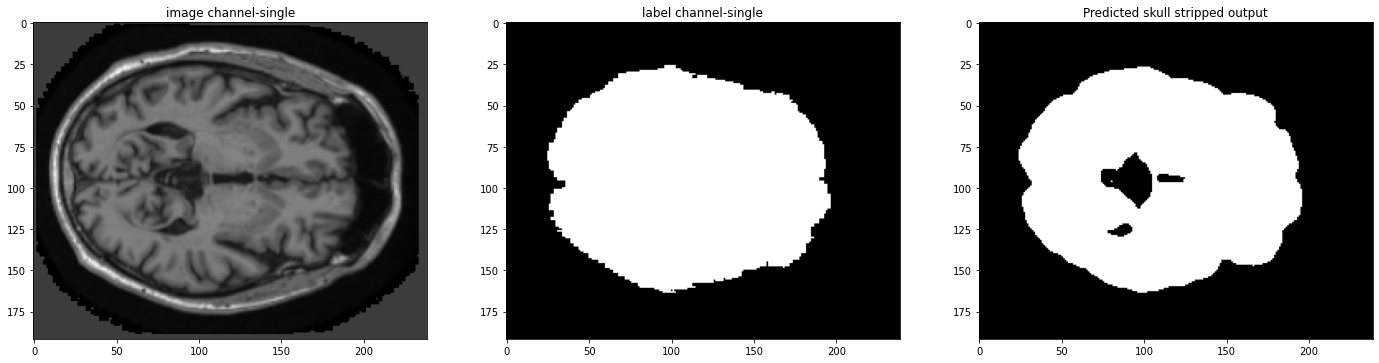

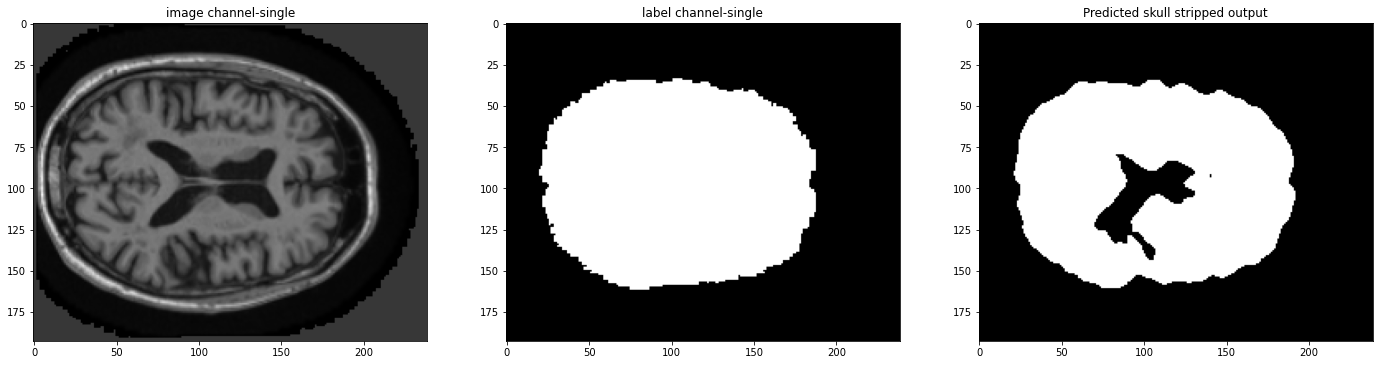

In [54]:
slice_nr = 76
nsubs = 5

# tfiles = []
# for i in range(5):
#     tfiles.extend([test_files[i]['image']])

tfiles = test_files[:10]

showSegSWIinference(learn, tfiles, val_transform, patch_size=(160, 160, 96), withMask = True, nsubs = nsubs, slice_nr = slice_nr)

In [60]:
test_files[:4]

[{'image': '/data-10tb/shared/skull/train-3d-iso/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_S9136_I32246.anat_T1_biascorr_iso.nii.gz',
  'label': '/data-10tb/shared/skull/train-3d-iso/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_S9136_I32246.anat_T1_biascorr_brain_mask_iso_nn.nii.gz'},
 {'image': '/data-10tb/shared/skull/train-3d-iso/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061206162204955_S12037_I31885.anat_T1_biascorr_iso.nii.gz',
  'label': '/data-10tb/shared/skull/train-3d-iso/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061206162204955_S12037_I31885.anat_T1_biascorr_brain_mask_iso_nn.nii.gz'},
 {'image': '/data-10tb/shared/skull/train-3d-iso/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061206163453030_S19041_I31906.anat_T1_biascorr_iso.nii.gz',
  'label': '/data-10tb/shared/skull/train-3d-iso/ADNI/ADNI_011_S_0005_MR_

In [ ]:
learn.unfreeze()
fname = f'{os.getcwd()}/BratsSkullStripSWI.pkl'
learn.export(fname=fname, pickle_protocol=2)

In [1]:
learn.unfreeze()
fname = f'{os.getcwd()}/BratsSkullStripSWI_40frz180epochs.pth'
learn.save(fname, with_opt=True, pickle_protocol=2)

NameError: name 'learn' is not defined

In [2]:
learn

NameError: name 'learn' is not defined